# Problem Discussion

## Histopathologic Cancer Detection
Identify metastatic tissue in histopathologic scans of lymph node sections

Link to Kaggle competition: https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

This competitions includes a labeled dataset with the goal of training a machine learning algorithm to accurately predict the existence of tumors within an image scan. The images are labeld as either:

    1 - Malignant tumor
    0 - Non-malignant tumor

This paper will train a convolutional neural network (CNN) on the training data and attempt to fine-tune the model for greater prediction accuracy.

## Exploratory Data Analysis (EDA)

### 1. Data Structure, Exploration, and Observations

#### Data View

In [11]:
import pandas as pd

labeled_df = pd.read_csv('data/train_labels.csv')
print(df.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


The labeled dataset contains image ids and a label. This indicates, that we will need to perform some data aggregation to prepare the data for PyTorch.

#### Data Shape

In [12]:
labeled_df.shape

(220025, 2)

This dataset contains 220025 images that are labeled for training.

#### Data Distribution

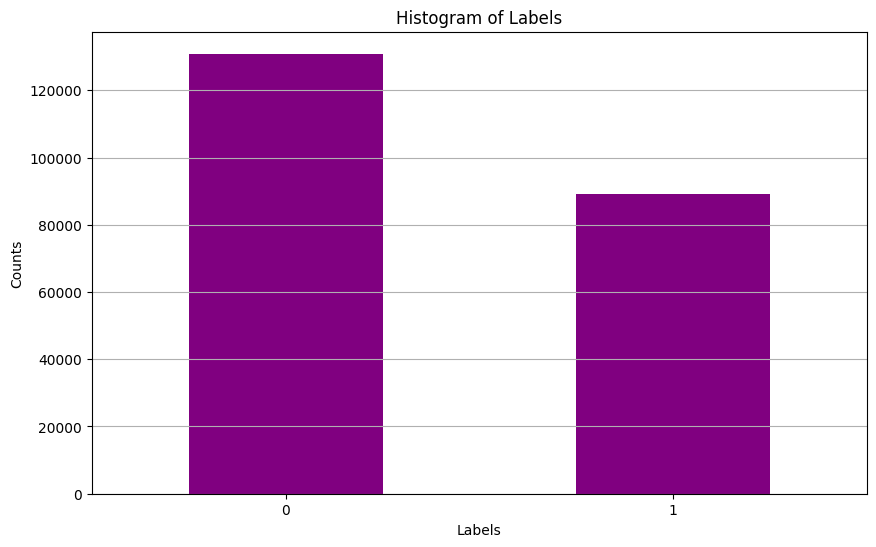

In [29]:
# get label counts
label_counts = labeled_df['label'].value_counts()

# plot histogram
plt.figure(figsize=(10, 6))  
label_counts.plot(kind='bar', color='purple')  
plt.title('Histogram of Labels') 
plt.xlabel('Labels') 
plt.ylabel('Counts')  
plt.xticks(rotation=0)  
plt.grid(axis='y') 
plt.show()  

This is a binary classification problem, so there are only two label options. The dataset contains more non-malignant images than malignant. We must consider ways to prevent bias in the model toward non-malignant predictions.

#### Image View

*Some data pre-processing was already done on the dataset (details below), so the code is not repeatable until after the pre-processing*

In [24]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# image paths
malignant_img_path = 'data/train/1'
non_malignant_img_path = 'data/train/0'

# get malignant and non-malignant ids
malignant_ids = labeled_df.loc[labeled_df['label']==1]['id'].values[:6]
print('Malignant ids:\n', malignant_ids)

non_malignant_ids = labeled_df.loc[labeled_df['label']==0]['id'].values[:6]
print('Non-malignant ids:\n', non_malignant_ids)

# create list of image paths 
def get_img_path(img_ids, base_path):
    img_paths = []
    for img_id in img_ids:
        path = base_path + '/' + img_id + '.tif'
        img_paths.append(path)
    return img_paths

malignant_img_paths = get_img_path(malignant_ids, malignant_img_path)
non_malignant_img_paths = get_img_path(non_malignant_ids, non_malignant_img_path)

# define image structure
def plot_image_grid(image_paths, cols=3):
    rows = (len(image_paths) + cols - 1) // cols  

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten() 

    for ax in axes:
        ax.axis('off') 

    # Plot each image in the grid
    for i, image_path in enumerate(image_paths):
        image = Image.open(image_path)
        axes[i].imshow(image)

    plt.tight_layout()
    plt.show()

Malignant ids:
 ['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f'
 'c3d660212bf2a11c994e0eadff13770a9927b731'
 '94fa32b29cc1c00403176c0795fffa3cfaa0f20e'
 '0b820b71670c039dd0a51333d1c919f471a9e940']
Non-malignant ids:
 ['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08'
 '068aba587a4950175d04c680d38943fd488d6a9d'
 'acfe80838488fae3c89bd21ade75be5c34e66be7'
 '559e55a64c9ba828f700e948f6886f4cea919261']


#### Malignant Images

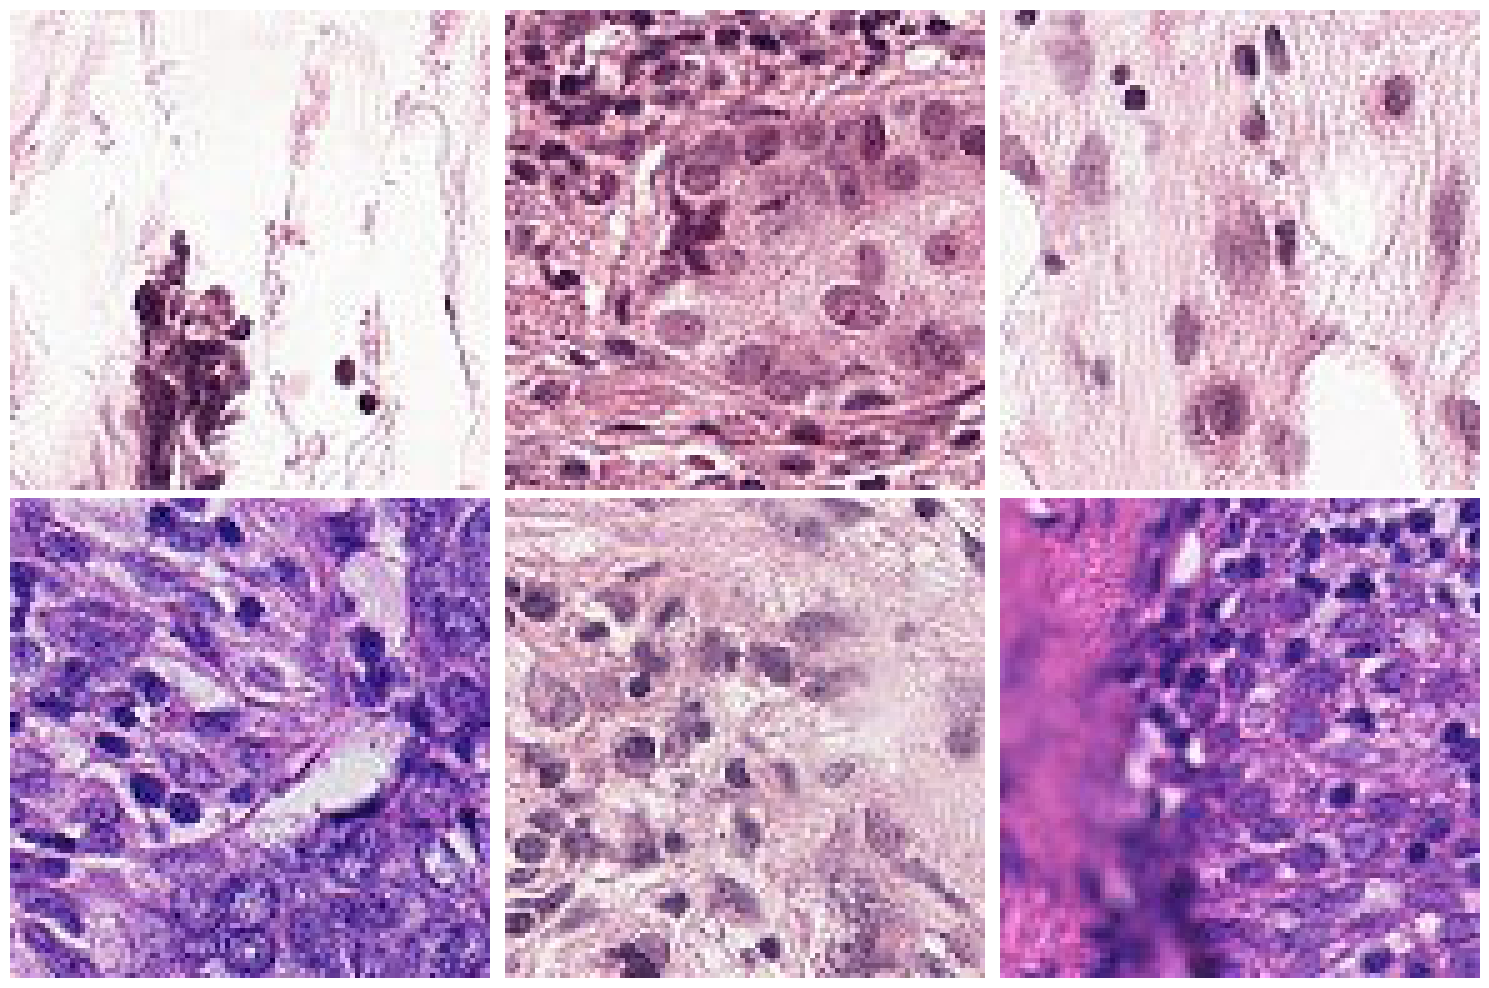

In [25]:
plot_image_grid(malignant_img_paths)

#### Non-malignant Images

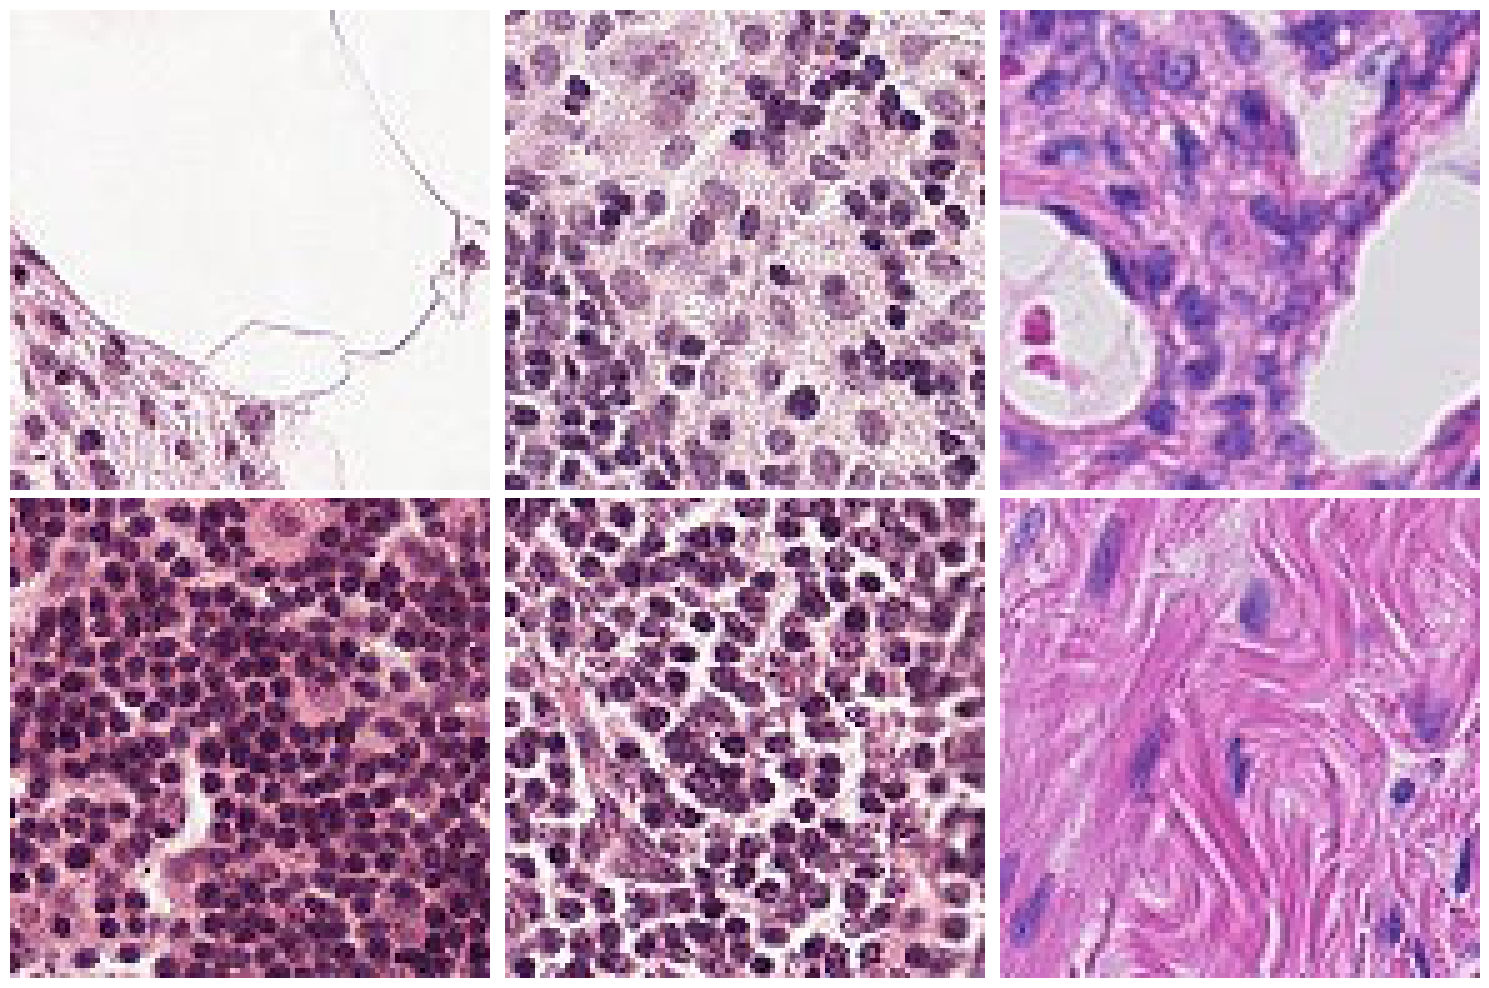

In [26]:
plot_image_grid(non_malignant_img_paths)

This is interesting. It is extremely difficult for the untrained eye to understand the difference between these sets of images. But we can deduce a few things that will need to be done to ensure model accuracy: 

    1. Image blurring is inconsistent. 
    2. Coloring and contrast are inconsistent.
    3. Location of tumor is inconsistent. 
    4. Zoom of image seems to be inconsistent.
    5. Unsure if orientation is consistent.

The data transformations and model architecture will need to address each of these observations.

#### Image Dimensions

Below, we will capture the number of pixels in each image.

In [32]:
# get all image paths
all_img_paths = malignant_img_paths + non_malignant_img_paths

# loop through image paths and collect distinct image dimensions
image_sizes = []
for img_path in all_img_paths:
    image = Image.open(img_path)
    if image.size not in image_sizes:
        image_sizes.append(image.size)

print(image_sizes)

[(96, 96)]


#### Summary of observations

* Training data favors non-malignant images
* Some images are effected by blurring more than others
* Images contain varying color and contrast
* Tumors can be present anywhere in the image
* Due to varying zoom, tumors can be expected to range from large to small sizes
* All images are 96x96 pixels

We will explore ways to address each of these observations as we progress.

## 2. Data Preprocessing and Cleaning

PyTorch requires the images to be structured according to classification files, so we will need to re-organize our training set to be compatible.

In [ ]:
import os

# read in the labels
labels = pd.read_csv('/data/train_labels.csv')

# create a folder for each class
for i in range(2):
    os.makedirs(f'/data/train/{i}', exist_ok=True)

# move the images to the correct folder
for i in range(len(labels)):
    image = labels.iloc[i][0]
    label = labels.iloc[i][1]
    os.rename(f'/data/train/{image}.tif', f'/data/train/{label}/{image}.tif')

This separates the training images in the train folder into two folders labeled according to the labeled training csv file. 

Now, we will consider what transformations we can do to increase the robustness and accuracy of the model. Here are the available transforms available from PyTorch torchvision library: https://pytorch.org/vision/stable/transforms.html

From the library documentation, a few transformations that can be applied to address the observations:

    1. Gaussian Blurring - Since the data has inconsistent blurring, we can apply gaussian blurring to the dataset to increase robustness of the model in case it encounters a blurred image on input.
    
    2. ColorJitter - We observed the data has varying color and contrast. This transform will increase the models ability to handle the varying input.

    3. RandomHorizaontalFlip - Since we are unsure of the orientation consistency of the scans, this will help the model adjust better to differing orientations on inputs.

    4. RadomCrop - This is documented to help the model focus on various parts of the image, which addresses the concern that tumors may appear anywhere in the image.

In the below code, the transfoms will be defined as a function for easy tuning later

In [30]:
import torchvision.transforms as transforms

def transformer():
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Randomly flip the image
        transforms.ColorJitter(),  # Randomly change the brightness, contrast, and saturation of an image
        transforms.RandomCrop(32, padding=4),  # Randomly crops the image
        transforms.ToTensor(),  # Convert the image to PyTorch tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
    ])
    return transform

## CNN Architecture

### 1. Base Architecture

The base architecture for a CNN is an input layer followed by a filter (convolutional layer), a pool, a fully connected layers, and then the output layer. 

![image.png](attachment:f7e3367c-4915-4d20-930e-5e847421b0f8.png)

Where:

    1. Input Layer consists of preprocessed images (using the transforms listed above).
    
    2. Convolutional Layer is a filtering layer that filters the pixels to extract basic elemental data from the image.
    
    3. Pool Layer is a layer that reduces dimensionality of the convolutional layer by pooling the results together into a smaller matrix of elemental data.
    
    4. Fully Connected Layers that act as a regular binary neural network classifier using the pooled data as an input.
    
    5. Output Layer returns either a 1 or a 0 for malignant tumors in the image

### 2. Successful Architectures

The base architecture can be expanded upon indefinitely, adding convolutional layers, trying different pooling methods, and even ensembling multiple networks together. 

#### GoogLeNet (2014)

![image.png](attachment:8ad93d9e-3ba8-4e3d-a68f-3e535737f8e0.png)

*Source: [medium.com](https://medium.com/the-modern-scientist/exploring-googlenet-a-revolutionary-deep-learning-architecture-8bb176a0facc#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjI4YTQyMWNhZmJlM2RkODg5MjcxZGY5MDBmNGJiZjE2ZGI1YzI0ZDQiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMDIyMDQ4NDg4Njc2NDk4MDEzODkiLCJlbWFpbCI6ImRpbGxvbi53aWxsaWFtczkzQGdtYWlsLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJuYmYiOjE3Mjc5MDEwOTAsIm5hbWUiOiJEaWxsb24gV2lsbGlhbXMiLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUNnOG9jSmpSUGpFU0M1UncwblJQeTJMOWJmSUpqOHRVQmJweVJCTzJ4M0lqWkFxcGFzeGtBPXM5Ni1jIiwiZ2l2ZW5fbmFtZSI6IkRpbGxvbiIsImZhbWlseV9uYW1lIjoiV2lsbGlhbXMiLCJpYXQiOjE3Mjc5MDEzOTAsImV4cCI6MTcyNzkwNDk5MCwianRpIjoiODBlMmM2MDhhZTE5ZjQwYWM3ZjZhNTVlOGZkNjQxNzcyNzdmNTRlOSJ9.yEsKfUi7rQQDG582L_woiefnZ7YsPOPQ-H8ikv0xrnQCwFcpjjbtmJ63N55n_L5EUfVmSUWl6O5WtdBJ1Rop29LVs5-m0ox6vu3nX8ZfyUZxThLm4tGss_Ub2SBQab9DKO8qPFz5t-_jjENTFlzQpMYccGWPcDKZSdowwAvFUMcvXlT50eSRD6T55_NYtssqe8Qg9bny_34zmA3UijOq7qhHHCFYj-1VtJxrwVTcTz7wVG-vBvfFdczX2S-beahs4AoomHA1tALeAnXYOF6ELwQXJCmToBJfWB3lNs7OSP7zTCXU1z1dhN01Lr9mBMBtBZW7p749rC8ascUVNNM8qQ)*

This architecture is quite complex and requires a large amount of processing power to properly train, but it serves as an example of how the base architecture can be expanded on.

According to [javapoint.com](https://www.javatpoint.com/googlenet-in-ai#:~:text=The%20GoogleNet%20architecture%20comprises%20multiple,parallel%20convolutions%20and%20dimensionality%20reduction.) the primary innovation acheived in this architecture was the introduction of an *inception module* that employes multiple convolutional filters to capture fine details and global patterns in various image sizes. 

#### AlexNet (2012)

![image.png](attachment:b84a86e9-e367-4287-bbbb-cc01fb29e167.png)

*Source: [Alex Krizhevsky](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)*

*Image cut from original paper*

From the paper: The neural network, which has 60 million parameters and 650,000 neurons, consists of five convolutional layers, some of which are followed by max-pooling layers, and three fully-connected layers with a final 1000-way softmax.

This architecture was so complex, that the Toronto team had to distribute computations across two GPU's (thus the split in the diagram between parallel layers). As stated in the paper, one GPU would run out of memory training the dataset.


### 3. Proposed Architecture - Model 1

We will begin with the base architecture and sequentially add convolutional layers until the AlexNet architecture is completed, measuring the loss histories with each implementation. 

Initial Hyperparameters:
* **Layer-1** - Convolutional layer with kernel size 5x5, stride of 4, padding of 1, and output channels of 32. ReLU activation function and max pooling of kernel size 3x3.
* **Fully Connected Layers** - 2, both linear (Using LazyLinear for ease on the first layer)
* **Loss Function** - torch.nn.CrossEntropyLoss() documented as best for classification [source](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)
* **Optimizer** - ADAM with learning rate of 0.001
* **Epochs** - 50

The following is the code implementing the architecture.

In [ ]:
# define the CNN architecture
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Model 1
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # Fully connected layers
        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.Linear(64, 2)

        # Loss, optimizer and epochs
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.epochs = 50

    def forward(self, x):
        # Convolutional layers
        x = self.layer1(x)

        # Flatten the tensor before the fully connected layers
        x = x.reshape(x.size(0), -1)

        # Fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = self.fc3(x)

        return x

Here is the training function that will train each model.

In [6]:
# function to train the neural network
# local functions
import torch


# functions the neural network
def train(train_loader, val_loader, model):
    # initiate transformer
    transformer = transform.transformer()

    # initiate loss function and optimizer
    criterion = model.criterion
    optimizer = model.optimizer

    # initiate functions loss history
    epoch_loss_history_train = []
    epoch_loss_history_val = []

    # functions the models
    for epoch in range(model.epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(
                    f'Epoch [{epoch + 1}/{model.epochs}], Step [{i + 1}/{len(train_loader)}]'
                )

        # Calculate and store the average loss for this epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_loss_history_train.append(epoch_loss)

        # Validate the model
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            for i, (inputs, labels) in enumerate(val_loader):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
            print(f'Epoch #{epoch} Validation Loss: {val_running_loss / len(val_loader)}')

        # Calculate and store the average loss for this epoch
        val_epoch_loss = val_running_loss / len(val_loader)
        epoch_loss_history_val.append(val_epoch_loss)

    return epoch_loss_history_train, epoch_loss_history_val


A function for the validation plot.

In [9]:
# Defines the loss plotting function
import matplotlib.pyplot as plt


# Plot the Cross Entropy Validation loss per epoch
def plot_loss(epoch_loss_history_train, epoch_loss_history_val):
    plt.plot(epoch_loss_history_train, label='Train Loss', color='black')
    plt.plot(epoch_loss_history_val, label='Validation Loss', color='yellow')
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.show()

And here is the main function to run all of the code.

In [ ]:
# main function to run the neural network

import json

# models name
model_name = 'model-1'

# main function
if __name__ == '__main__':
    # initiate the models
    model = cnn.CNN()

    # route to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # train the models
    path = '/data/train'
    loss_history = train_nn.train(path, model)

    # save the models
    torch.save(model.state_dict(),
               f'/results/models/{model_name}.pth')

    print('Model trained and saved')

    # visualize the loss history
    plt.plot(loss_history)
    plt.show()

    # save the loss history as json
    with open(f'results/statistics/loss_history_{model_name}.json','w') as file:
        file.write(json.dumps(loss_history))

## Results and Analysis

#### Analysis of Model 1 

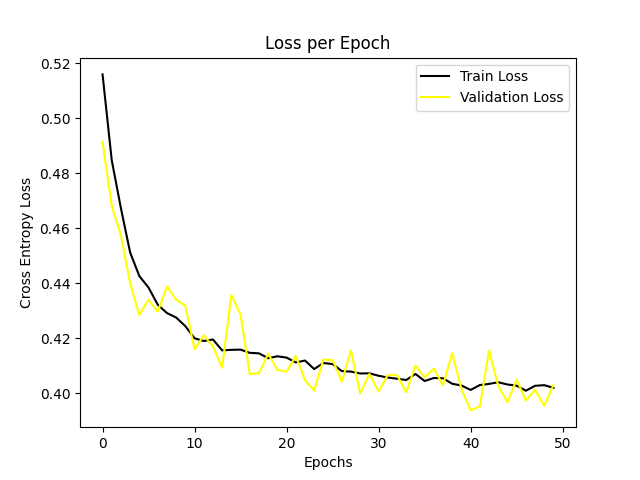

Now, a second convolutional layer will be added to see if model performance improves.

The next convolutional layer will have:
* Input size of 32 and output size of 64
* Kernel size of 3x3 with a stride of 2
* Relu activation
* Max pooling with kernel size 2x2

Here is the CNN for the next iteration

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )

        # Fully connected layers
        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.Linear(64, 2)

        # Loss, optimizer and epochs
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.epochs = 25

    def forward(self, x):
        # Convolutional layers
        x = self.layer1(x)
        x = self.layer2(x)

        # Flatten the tensor before the fully connected layers
        x = x.reshape(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

#### Analysis of Model 2

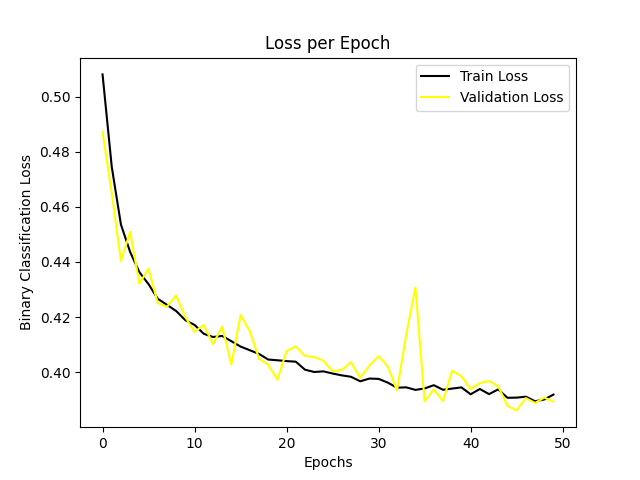

This yielded much better results.

The next iteration will be another convolutional layer to see if performance can improve even more.

In adding another convolutional layer, the max pooling had to be removed in the second layer because the pixels were already reduced to 1x1, and could not be reduced anymore. To remedy this, the first layer's stride was reduced and the max pooling was removed from the second layer.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.LazyLinear(64),
            nn.ReLU(inplace=True)
        )
        self.fc2 = nn.LazyLinear(1)

        # Loss, optimizer and epochs
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.epochs = 50

    def forward(self, x):
        # Convolutional layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # Flatten the tensor before the fully connected layers
        x = x.reshape(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

#### Analysis of Model 3

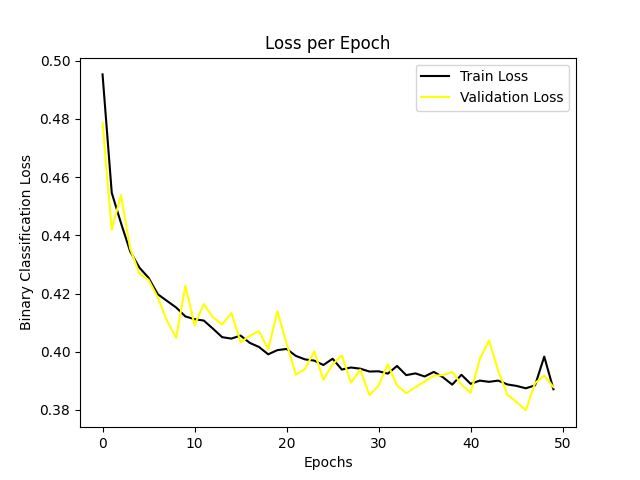

Adding another convolutional layer did increase model performance! Given time and computational power, it would be interesting to keep this trend going and find a convergence of model depth, but each iteration's training time was about the length of a movie. One final model will be trained with different hyperparameters.

#### Hyperparameter Tuning

Since the model takes a long time to converge (40+ epochs) and training time is substantially long (~2hrs per model), the following can be used to speed up convergence:

1. Increase Batch Size
2. Increase Learning Rate

The final model will be the architecture of Model 3, but the batch size increased to 100 and the learning rate increased from 0.001 to 0.0015.

#### Analysis of Model 4

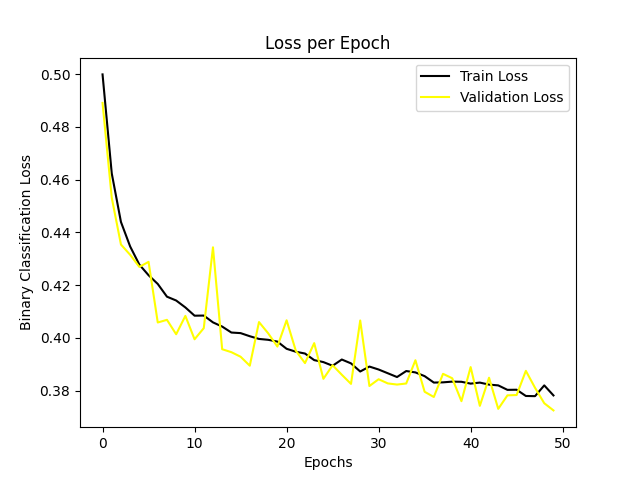

Here, we see that convergence did increase slightly, as BCE loss acheived less than 40% by 20 epochs as apposed to slightly later in Model #3

Now, model 4 will be used on the test data to see the final result.



### Final Kaggle Results

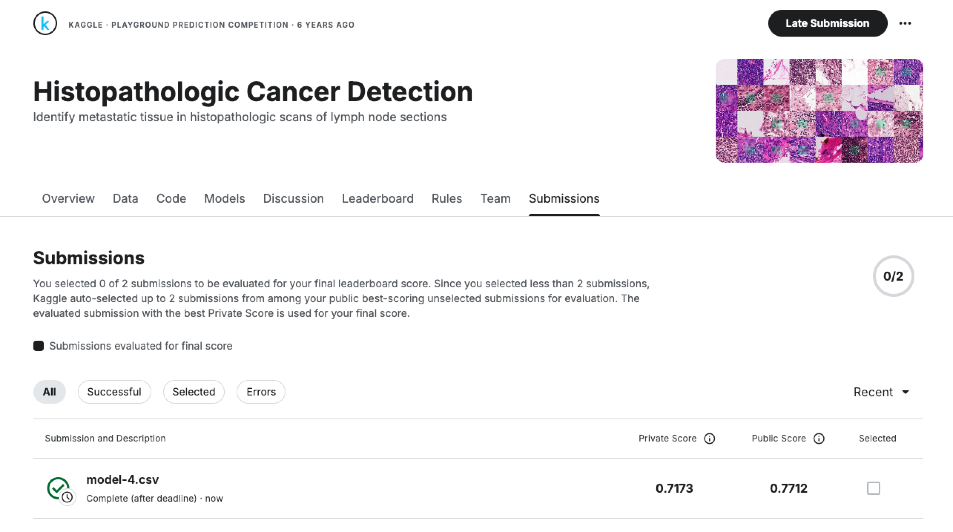

Overall score of 71%, placing #1071 on the leaderboard.

## Conclusion

This project explored different architectures for CNN's and learned a few things:

1. Increasing model depth with more convolutional layers increased model performance.
2. Increasing batch size and learning rate slightly increased convergence time with no loss to model performance.

More could certainly be done given enough time. More convolutional layers could be added until performance no longer increased. More fully connected layers could be added as well. Even inception modules could be added to see the effect on classification. 